In [1]:
import os
import pdb
import ntpath
import functools
import numpy as np
import scipy as sp
from scipy.stats import pearsonr
from scipy.sparse.linalg import svds
from scipy.spatial.distance import cdist, pdist, squareform
import matplotlib as mpl
import matplotlib.pylab as plt
import FileDialog  # for creating binary
from Tkinter import Tk
import tkFileDialog
from sklearn.cluster import AgglomerativeClustering, SpectralClustering, KMeans
from sklearn.neighbors import kneighbors_graph
import librosa
import djitw
from feature_extraction import extractFeature
from statistics import lpf, findElbow
from sklearn.metrics import silhouette_score
import peakutils
from seasonal import fit_trend
%matplotlib inline

In [2]:
def compute_2d_fft(data, window_length, hop_length):
    start = 0
    ffts = []
    while start <= data.shape[1] - window_length:
        fft = np.fft.fft2(data[:, start:start + window_length])
        fft = np.abs(np.fft.fftshift(fft))
        ffts.append(fft)
        start += hop_length
    return np.array(ffts)    

In [3]:
def extract_features(file_path, file_ext, feature, cutoff=0.1, sr=1, order=1,
                     beat_sync=True, n_fft=8, hop_length=4, scale=0.0, round_to=0.0, normalize=0):
    # set parameters
    save_feat = True

    # extract features
    feats = {}
    feats[feature], beat_times = extractFeature(
        file_path, file_ext, feature, scale=0.0, round_to=0.0, normalize=0,
        transpose=False, save=save_feat, beat_sync=beat_sync)
    # Compute log-amplitude
    feats[feature] = librosa.logamplitude(
        feats[feature], ref_power=feats[feature].max())
    # L2 normalize the columns, i.e. each frame
    feats[feature] = librosa.util.normalize(feats[feature], norm=2., axis=0)
    # project feature
    feats['SVD({})'.format(feature)] = svd(feats[feature], n_singv=0, threshold=.6, inc_proj=True)[1]


    # low pass filtered signal
    feats['LPF({})'.format(feature)] = lpf(feats[feature], cutoff, sr, order)

    # low pass filtered svd signal
    feats['LPF(SVD({}))'.format(feature)] = lpf(feats['SVD({})'.format(feature)], cutoff, sr, order)    
    
    """
    # Extract 2D-FFT
    data = compute_2d_fft(feats[feature], n_fft, hop_length)
    #data = data.T
    # transpose and reshape FFT data to have (frequencies, n_obs)
    #data = data.reshape(data.shape[0]*data.shape[1], data.shape[2])
    feats['2D-FFT({})'.format(feature)] = data
    
    # Extract 2D-FFT with SVDed feature
    data = compute_2d_fft(feats['SVD({})'.format(feature)], n_fft, hop_length)
    #data = data.T
    # transpose and reshape FFT data to have (frequencies, n_obs)
    #data = data.reshape(data.shape[0]*data.shape[1], data.shape[2])
    feats['2D-FFT(SVD({}))'.format(feature)] = data
    """
    
    """
    # extract power spectrum of feature, remove F0
    data = np.array([librosa.core.stft(f, n_fft, hop_length)[1:, :]
                     for f in feats[feature]])
    # transpose and reshape FFT data to have (frequencies, n_obs)
    data = data.reshape(data.shape[0]*data.shape[1], data.shape[2])
    feats['FFT({})'.format(feature)] = np.abs(data) ** 2

    
    # extract power spectrum of SVD(feature), remove F0
    data = np.array([librosa.core.stft(f, n_fft, hop_length)[1:, :]
                     for f in feats['SVD({})'.format(feature)]])
    # transpose and reshape FFT data to have (frequencies, n_obs)
    data = data.reshape(data.shape[0]*data.shape[1], data.shape[2])
    feats['FFT({})'.format('SVD({})'.format(feature))] = np.abs(data) ** 2
    """

    return feats, beat_times

In [52]:
def distance_fn(i, X, window, step_size):
    # return np.sqrt(np.sum(
    # X[:, i:i+window] - X[:, i+step_size:i+step_size+window]) ** 2))
    # (pearsonr(X[:, i:i+window].flatten(),
    #   X[:, i+step_size:i+step_size+window].flatten())[0]+1)*.5
    # features are already normalized, equals to cosine distance
    x = X[:, i:i+window].flatten()
    y = X[:, i+step_size:i+step_size+window].flatten()
    distance = 1 - np.dot(x, y) / (np.linalg.norm(x, 2) * np.linalg.norm(y, 2))
    # distance = np.arccos(cos_sim) / np.pi  # angular distance
    return distance

In [53]:
def compute_dtw_distance(x, y, metric):
    distance_matrix = sp.spatial.distance.cdist(x, y, metric=metric)
    # Non-diagonal additive path penalty is the median of the sim matrix
    add_pen = np.median(distance_matrix)
    x_indices, y_indices, cost = djitw.dtw(
        distance_matrix, gully=.96, additive_penalty=add_pen, inplace=False)
    # Normalize score by path length
    cost /= float(len(x_indices))
    # Normalize score by mean distance matrix value within path chunk
    cost /= distance_matrix[
        x_indices.min():x_indices.max()+1,
        y_indices.min():y_indices.max()+1].mean()
    if np.isnan(cost):
        pdb.set_trace()
    # cost is unbounded
    return cost

In [54]:
def compute_segmentation(data, window, step_size, kernel_size, flip=False, detrend=True):
    # compute localized distances
    d1 = np.array(map(functools.partial(distance_fn,
                                        X=data,
                                        window=window,
                                        step_size=step_size),
                         xrange(0, data.shape[1]-(step_size+window*2))))
    """
    d2 = np.array(map(functools.partial(distance_fn,
                                        X=data,
                                        window=window,
                                        step_size=step_size*2),
                         xrange(0, data.shape[1]-(step_size*2+window*2))))

    d3 = np.array(map(functools.partial(distance_fn,
                                        X=data,
                                        window=window,
                                        step_size=step_size*3),
                         xrange(0, data.shape[1]-(step_size*3+window*2))))

    d4 = np.array(map(functools.partial(distance_fn,
                                        X=data,
                                        window=window,
                                        step_size=step_size*4),
                         xrange(0, data.shape[1]-(step_size*4+window*2))))

    d1[:len(d2)] = (d1[:len(d2)] + d2)/2
    d1[:len(d3)] = (d1[:len(d3)] + d3)/2
    d1[:len(d4)] = (d1[:len(d4)] + d4)/2
    """
    
    distances = d1
    if flip:
        distances *= -1

    if detrend:
        distances = distances - fit_trend(distances)
    # find peaks in distance
    peaks, filtered = find_peaks(distances, kernel_size)
    return peaks, distances, filtered

In [55]:
def find_peaks(data, kernel_size):
    # create kernel
    window = sp.signal.general_gaussian(kernel_size, p=1, sig=4)
    # zero padding not to change shape of data
    data = np.append(np.repeat(data[0], kernel_size/2), data)
    # convolve, scale, find peaks
    filtered = sp.signal.fftconvolve(data, window, mode='same')[kernel_size/2:]
    filtered *= np.average(data) / np.average(filtered)
    peaks = sp.signal.argrelmax(filtered, 0, kernel_size/2)[0]
    peaks = np.insert(peaks, 0, 0)
    """
    #peaks = peakutils.indexes(data, thres=0.2, min_dist=4)
    peaks = peakutils.indexes(filtered, thres=0.01, min_dist=2)
    peaks = np.insert(peaks, 0, 0)
    """
    return peaks, filtered

In [56]:
def compute_clusters_dtw(matrix, algorithm, segments, to_similarity, eps=0.01):
    if to_similarity:
        matrix = np.exp(-matrix)
    if algorithm == 'spectral':
        K = int(np.linalg.eig(sim_mat)[0][0])
        labels = SpectralClustering(
            n_clusters=K, n_init=32, affinity='precomputed').fit_predict(
                matrix)
    elif algorithm == 'dbscan':
        labels = DBSCAN(eps=0.5, min_samples=2,
                        metric='precomputed').fit_predict(matrix)
    else:
        raise Exception("Algorithm {} not supported".format(algorithm))

    # choose centroids
    centroids = np.array([np.random.choice(segments[labels == i], 1)
                          for i in xrange(max(labels)+1)])
    indices = [0]
    for i in xrange(len(centroids)):
        indices.append(indices[-1]+centroids[i][0].shape[0])

    centroids_ravel = centroids[0][0]
    for i in xrange(1, len(centroids)):
        centroids_ravel = np.vstack((centroids_ravel, centroids[i][0]))

    return centroids_ravel, labels, indices

In [57]:
def compute_clusters(data, length, algorithm):
    # with Agglomerative Clustering
    K_MIN, K_MAX = 2, 12
    if algorithm == 'agglomerative':
        knn_graph = kneighbors_graph(data, K_MAX, include_self=False)
        clustering = [AgglomerativeClustering(linkage='complete',
                                              connectivity=knn_graph,
                                              n_clusters=k).fit(data)
                      for k in xrange(K_MIN, K_MAX+1)]
    elif algorithm == 'kmeans':
        clustering = [KMeans(n_clusters=k, max_iter=512, n_init=16).fit(data)
                      for k in xrange(K_MIN, K_MAX+1)]        
    elif algorithm == 'spectral':
        clustering = [SpectralClustering(n_clusters=k,
                                         n_init=16,
                                         affinity='rbf').fit(data)
                      for k in xrange(K_MIN, K_MAX+1)]
    else:
        raise Exception("Algorithm {} not supported".format(algorithm))

    scores = [silhouette_score(data,
                               clustering[x].labels_,
                               metric='euclidean')
              for x in xrange(len(clustering))]

    # get best clusters
    idx_best = findElbow(np.dstack((xrange(K_MIN, K_MAX+1), scores))[0])
    idx_best = min(idx_best+1, 12)
    clustering = clustering[idx_best]
    labels = clustering.labels_

    # compute mean centroids
    centroids = np.array([data[labels == i].mean(axis=0)
                          for i in xrange(max(labels)+1)])

    if centroids.shape[1] == 3 * length:
        centroids = centroids.reshape(
            1, centroids.shape[0]*length, centroids.shape[1]/length)
    else:
        centroids = centroids.reshape(
            centroids.shape[0] * length,
            centroids.shape[1] / length)

    indices = [i*length for i in xrange(len(centroids))]
    
    # update labels with different metric
    # dists = cdist(centroids, data, metric='cosine')
    # labels = np.argmin(dists, axis=0)
    return centroids, labels, indices

In [58]:
def get_segments(data, peaks):
    segments = [data[peaks[i]:peaks[i+1]] for i in xrange(len(peaks)-1)]
    segments.append(data[peaks[-1]:-1])
    return np.array(segments)

In [59]:
def svd(data, n_singv=0, threshold=0.9, inc_proj=False):
    lsv, sv, rsv = svds(data, k=data.shape[0]-1, which='LM')

    # find number of singular values that explain 90% of variance
    n_singv = 1
    while np.sum(sv[-n_singv:]) / np.sum(sv) < threshold:
        n_singv += 1
    print "Using {} singular vectors".format(n_singv)
    # compute reduced data and data projected onto principal components space
    data_redu = np.dot(data, rsv.T)
    if inc_proj:
        data_proj = np.dot(lsv[:, -n_singv:],
                           np.dot(np.diag(sv[-n_singv:]), rsv[-n_singv:, ]))
        return data_redu, data_proj
    return data_redu

In [150]:
beat_sync = True
sr = 1
cutoff = .01
scale=0
round_to=0
normalize=0
flip = False

# set parameters
if beat_sync:
    n_fft = 4
    hop_length = 2
    window = 1
    step_size = 1
    kernel_size = 16
else:
    n_fft = 32
    hop_length = 16
    window = 4
    step_size = 2
    kernel_size = 4

filepath = '/Users/rafaelvalle/Desktop/research/music_segmentation/data/Radiohead/01 Burn the Witch.mp3'
feature='cqt'    
clustering_algo='kmeans'

In [151]:
# extract features
file_path, file_ext = os.path.splitext(filepath)
feats, beat_times = extract_features(
    file_path, file_ext, feature, cutoff=cutoff, sr=sr, scale=scale, round_to=round_to, normalize=normalize,
    beat_sync=beat_sync, n_fft=n_fft, hop_length=hop_length)

# convert beat_times to nicely formatted strings
beat_times_str = np.array(
    ['{}:{}'.format(int(x/60), int(x % 60)) for x in beat_times])

Using 3 singular vectors


In [152]:
# perform segmentation
print '\tSegmentation'
peaks = {}
distances = {}
distances_filtered = {}
segments = {}
for k, v in feats.items():
    peaks[k], distances[k], distances_filtered[k] = compute_segmentation(
        v, window, step_size, kernel_size, flip=flip)
    # computes segments
    segments[k] = get_segments(v.T, peaks[k])

	Segmentation


In [153]:
# perform clustering using DTW distances
print '\tClustering'
clustering = {}
for k, v in feats.items():
    if '2D' in k:
        clustering[k] = compute_clusters(v.reshape(v.shape[0], v.shape[1]*v.shape[2]), 1, clustering_algo)
    else:
        clustering[k] = compute_clusters(v.T, 1, clustering_algo)

	Clustering


In [154]:
# compute pair-wise distances using DTW
"""
print '\tDTW'
dtw_distances = {}
for k, v in segments.items():
    dists = np.zeros((len(v), len(v)))
    for i in xrange(len(v)):
        for j in xrange(len(v)):
            if i == j:
                dists[i, j] = 0.0
            else:
                dists[i, j] = compute_dtw_distance(
                    v[i], v[j], 'cosine')
    dtw_distances[k] = dists

# perform clustering using DTW distances
print '\tClustering'
clustering = {}
for k, v in dtw_distances.items():
    if np.isnan(v).any():
        pdb.bset_trace()
    clustering[k] = compute_clusters_dtw(v, 'dbscan', segments[k], False)
"""    

"\nprint '\tDTW'\ndtw_distances = {}\nfor k, v in segments.items():\n    dists = np.zeros((len(v), len(v)))\n    for i in xrange(len(v)):\n        for j in xrange(len(v)):\n            if i == j:\n                dists[i, j] = 0.0\n            else:\n                dists[i, j] = compute_dtw_distance(\n                    v[i], v[j], 'cosine')\n    dtw_distances[k] = dists\n\n# perform clustering using DTW distances\nprint '\tClustering'\nclustering = {}\nfor k, v in dtw_distances.items():\n    if np.isnan(v).any():\n        pdb.bset_trace()\n    clustering[k] = compute_clusters_dtw(v, 'dbscan', segments[k], False)\n"

### Similarity Matrices

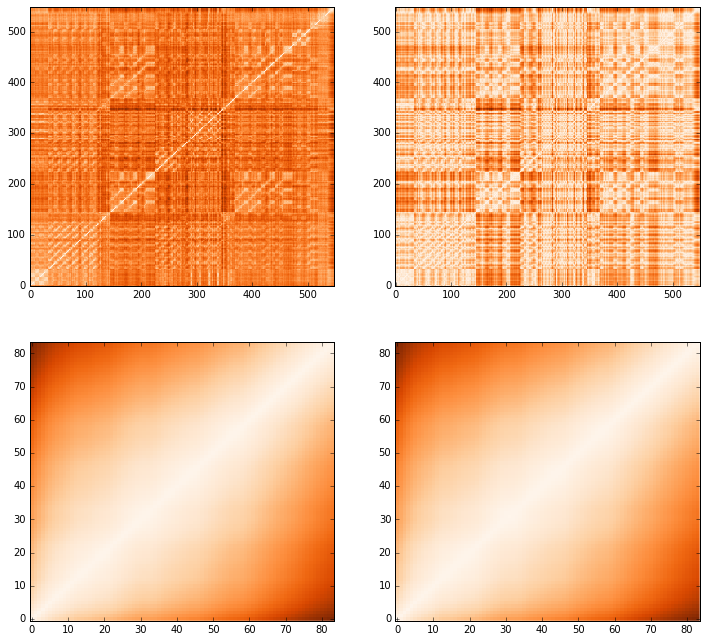

In [155]:
fig, axes = plt.subplots(2, 2, figsize=(12, 11))
axes[0, 0].imshow(squareform(pdist(feats['cqt'].T)),
              interpolation='none',
              origin='low',
              aspect='auto',
              cmap=plt.cm.Oranges)   
axes[0, 1].imshow(squareform(pdist(feats['SVD(cqt)'].T)),
              interpolation='none',
              origin='low',
              aspect='auto',
              cmap=plt.cm.Oranges)
axes[1, 0].imshow(squareform(pdist(feats['LPF(cqt)'])),
              interpolation='none',
              origin='low',
              aspect='auto',
              cmap=plt.cm.Oranges)   
axes[1, 1].imshow(squareform(pdist(feats['LPF(SVD(cqt))'])),
              interpolation='none',
              origin='low',
              aspect='auto',
              cmap=plt.cm.Oranges)

/usr/local/lib/python2.7/site-packages/ipykernel/__main__.py:53: VisibleDeprecationWarning: boolean index did not match indexed array along dimension 0; dimension is 549 but corresponding boolean dimension is 548


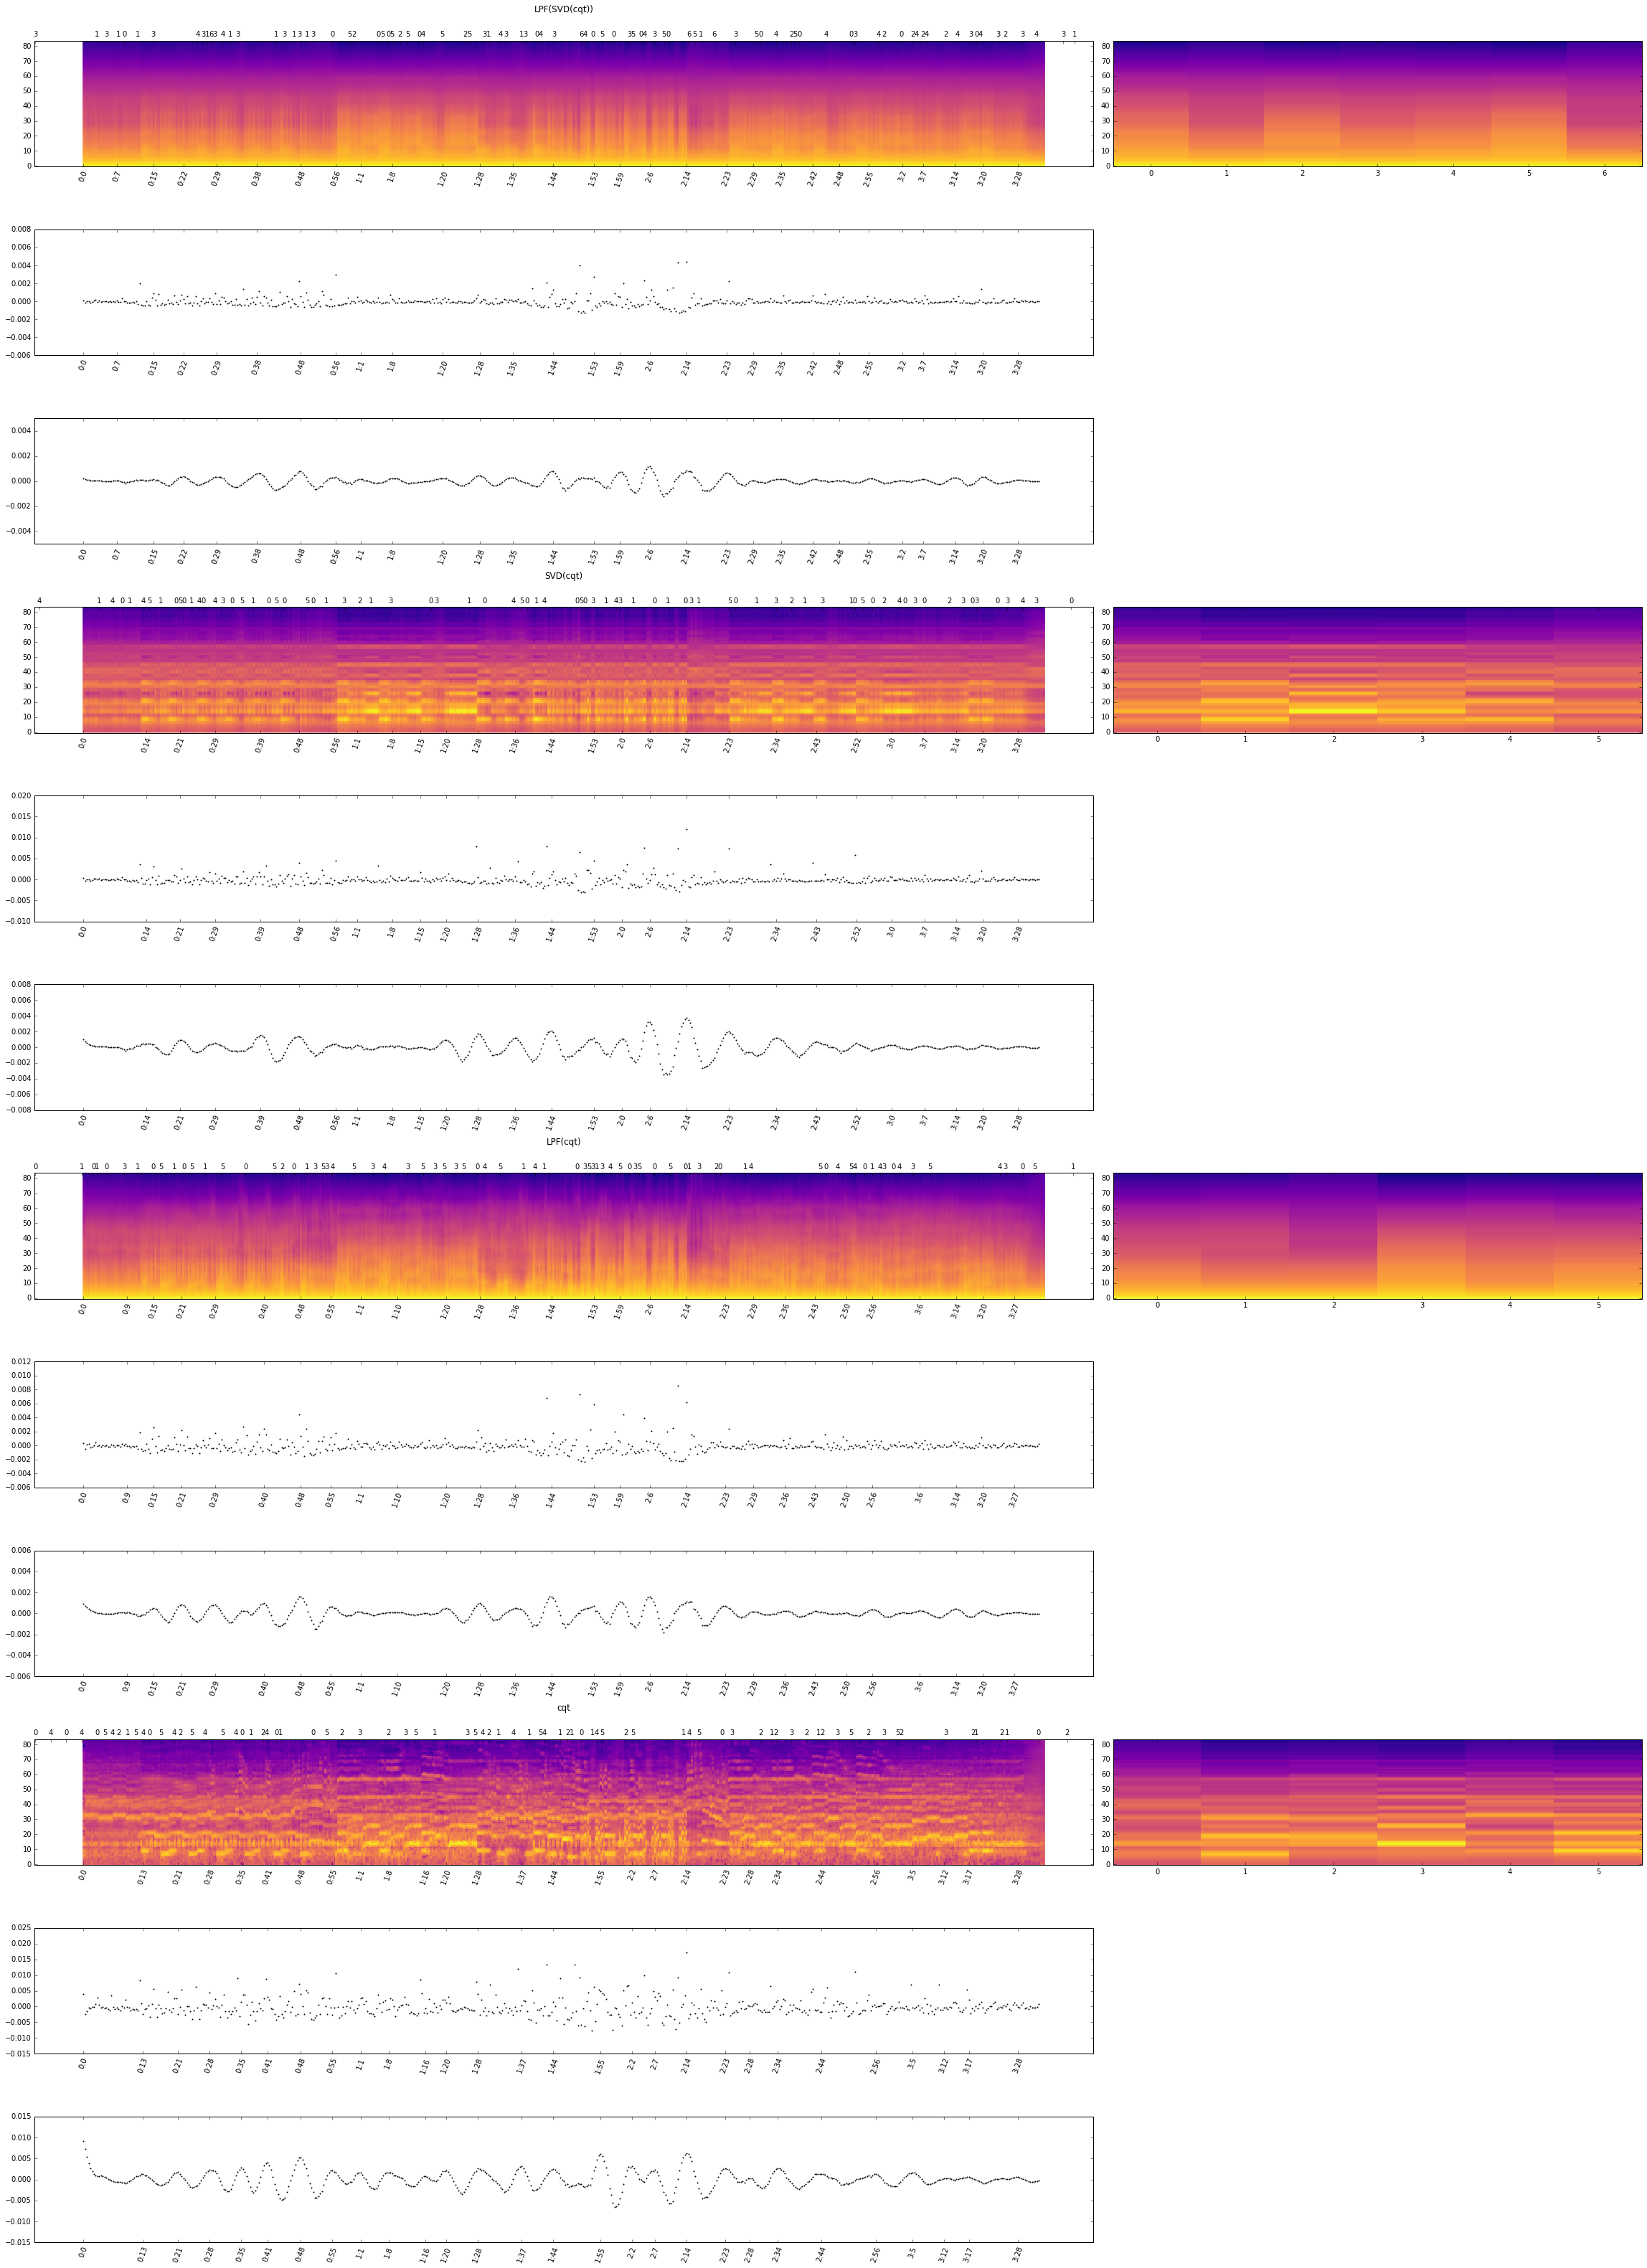

In [156]:
# clean axes and update data individually
plt.suptitle(ntpath.basename(file_path))
fig = plt.figure(figsize=(32, 44))
gs = mpl.gridspec.GridSpec(len(feats)*3, 2, width_ratios=[16, 8])
i = 0
for k, v in feats.items():
    ax_plt = fig.add_subplot(gs[i, 0])
    ax_plt.set_title(k, y=1.2)    
    if '2D' in k:
        for b in xrange(0, v.shape[2]):            
            ax_plt.imshow(np.hstack(v[:,:,b][:, :, np.newaxis]),
                          interpolation='none',
                          origin='low',
                          aspect='auto',
                          cmap=plt.cm.plasma)        
    else:
        # plot feature
        ax_plt.imshow(feats[k],
                      interpolation='none',
                      origin='low',
                      aspect='auto',
                      cmap=plt.cm.plasma)
#    for p in peaks[k]:
#        ax_plt.axvline(p, color='k', linestyle='--', alpha=0.5)
#    ax_plt.set_xticks(peaks[k])
#    ax_plt.set_xticklabels(beat_times_str[changes], rotation=70)

    # plot clustering on raw feature
    changes = np.hstack((clustering[k][1][:-1] != clustering[k][1][1:]))
    
    for c in xrange(changes.shape[0]-1):
        if changes[c] and changes[c+1]:
            changes[c] = False

    cur_label = clustering[k][1][0]
    for c in xrange(1, changes.shape[0]-1):
        if changes[c] == True:
            if clustering[k][1][c] == cur_label:
                changes[c] = False
            cur_label = clustering[k][1][c]                
    """
    for c in xrange(changes.shape[0]):
        if changes[c]:
            ax_plt.axvline(c, color='r', alpha=0.5)
    """

    ax_plt.set_xticks(np.argwhere(changes)[:,0])
    ax_plt.set_xticklabels(beat_times_str[np.argwhere(changes)[:,0]], rotation=70)
            
    ax_twin = ax_plt.twiny()
    ax_twin.set_xlim(ax_plt.get_xlim())
    ax_twin.set_xticks(np.argwhere(changes)[:, 0])
    ax_twin.set_xticklabels(clustering[k][1][changes])
    ax_twin.grid(False)        
    
    # plot clusters
    ax = fig.add_subplot(gs[i, 1])
    if '2D' in k:        
        clusters = clustering[k][0].reshape(clustering[k][0].shape[0], v.shape[1], v.shape[2])
        for b in xrange(0, clusters.shape[2]):            
            ax.imshow(np.hstack(clusters[:,:,b][:, :, np.newaxis]),
                      interpolation='none',
                      origin='low',
                      aspect='auto',
                      cmap=plt.cm.plasma)    
    else:
        ax.imshow(
            clustering[k][0].T,
            interpolation='none',
            origin='low',
            aspect='auto',
            cmap=plt.cm.plasma)
    ax.set_xticks(clustering[k][2])
    ax.set_xticklabels(xrange(max(clustering[k][1])+2))

    # plot distance funcs
    ax = fig.add_subplot(gs[i+1, 0], sharex=ax_plt)
    ax.scatter(xrange(len(distances[k])), distances[k], s=1)
    #for p in peaks[k]:
    #    ax.axvline(p, color='k', linestyle='--', alpha=0.5)
    ax.set_xticks(peaks[k])
    ax.set_xticklabels(beat_times_str[peaks[k]], rotation=70)

    ax = fig.add_subplot(gs[i+2, 0], sharex=ax_plt)
    ax.scatter(xrange(len(distances_filtered[k])), distances_filtered[k], s=1)
    #for p in peaks[k]:
    #    ax.axvline(p, color='k', linestyle='--', alpha=0.5)
    ax.set_xticks(peaks[k])
    ax.set_xticklabels(beat_times_str[peaks[k]], rotation=70)

    i+=3

plt.tight_layout()

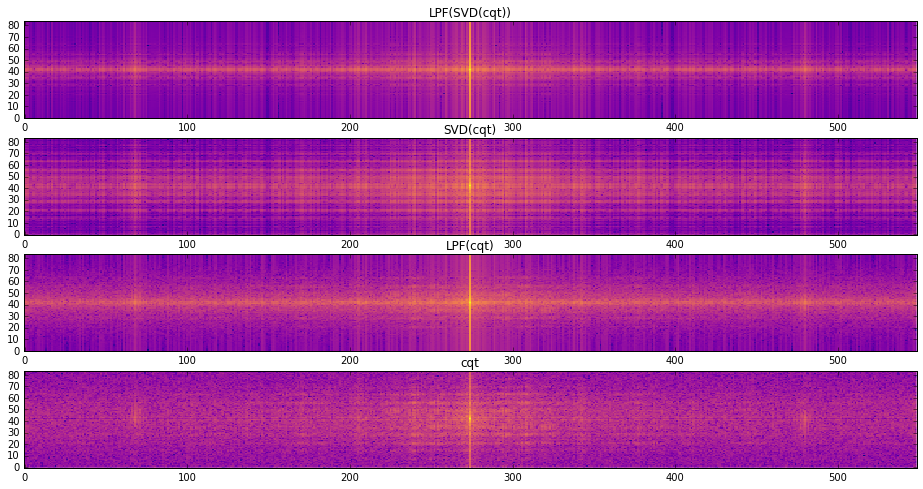

In [157]:
fig, axes = plt.subplots(len(feats.keys()), 1, figsize=(16, 8))
i = 0
for k, v in feats.items():
    if '2D' in k:
        v = v.reshape(v.shape[0], v.shape[1]*v.shape[2]).T
    axes[i].set_title(k)
    axes[i].imshow(np.log(np.fft.fftshift(np.abs(np.fft.fft2(v)**2))),
                   interpolation='none',
                   origin='low',
                   aspect='auto',
                   cmap=plt.cm.plasma)
    i+= 1
